In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [ ]:
base_path = '/content/drive/MyDrive/Project Talaria(IoT)/Pif3_Dataset'

selected_features = ['HR', 'Spo2', 'AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ',
                     'Aroll', 'Apitch', 'Groll', 'Gpitch', 'Gy', 'Combroll', 'Combpitch']

def load_and_combine_pid_data(pid_folder):
    try:
        pid_name = os.path.basename(pid_folder)

        pid_num = pid_name.replace('PID', '')
        file_prefix = f'PID_{pid_num}'

        bpm_file = os.path.join(pid_folder, f'{file_prefix}_BPM.csv')
        sensor_file = os.path.join(pid_folder, f'{file_prefix}.csv')

        if not os.path.exists(bpm_file) or not os.path.exists(sensor_file):
            print(f"Missing files in {pid_name}")
            return None

        df_bpm = pd.read_csv(bpm_file)
        df_sensor = pd.read_csv(sensor_file)

        df_bpm.columns = df_bpm.columns.str.strip()
        df_sensor.columns = df_sensor.columns.str.strip()

        col_mapping = {}
        for col in df_bpm.columns:
            col_lower = col.lower()
            if col_lower == 'hr':
                col_mapping[col] = 'HR'
            elif col_lower == 'spo2':
                col_mapping[col] = 'Spo2'

        if col_mapping:
            df_bpm = df_bpm.rename(columns=col_mapping)

        if 'Datetime' not in df_bpm.columns or 'Datetime' not in df_sensor.columns:
            print(f"Missing Datetime column in {pid_name}")
            return None

        min_length = min(len(df_bpm), len(df_sensor))

        df_sensor_trimmed = df_sensor.iloc[:min_length].copy()
        df_bpm_trimmed = df_bpm.iloc[:min_length].copy()

        if 'HR' in df_bpm_trimmed.columns:
            df_sensor_trimmed['HR'] = df_bpm_trimmed['HR'].values
        if 'Spo2' in df_bpm_trimmed.columns:
            df_sensor_trimmed['Spo2'] = df_bpm_trimmed['Spo2'].values

        available_features = [col for col in selected_features if col in df_sensor_trimmed.columns]

        if 'Datetime' not in df_sensor_trimmed.columns:
            print(f"Datetime column missing in {pid_name}")
            return None

        if len(available_features) < 10:
            print(f"Insufficient features in {pid_name}: only {len(available_features)} found")
            return None

        columns_to_keep = ['Datetime'] + available_features
        df_result = df_sensor_trimmed[columns_to_keep].copy()
        df_result['PID'] = pid_name

        existing_features = [f for f in available_features if f in df_result.columns]
        df_result = df_result.dropna(how='all', subset=existing_features)

        return df_result

    except Exception as e:
        print(f"Error processing {pid_folder}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

pid_folders = sorted(glob.glob(os.path.join(base_path, 'PID*')))
print(f"Found {len(pid_folders)} participant folders\n")

all_data = []
successful_loads = 0
failed_loads = 0

for pid_folder in pid_folders:
    df = load_and_combine_pid_data(pid_folder)
    if df is not None and len(df) > 0:
        all_data.append(df)
        successful_loads += 1
        print(f"Loaded {os.path.basename(pid_folder)}: {len(df)} rows, {len([c for c in selected_features if c in df.columns])} features")
    else:
        failed_loads += 1

print(f"\nSuccessfully loaded: {successful_loads}/{len(pid_folders)} participants")
print(f"Failed: {failed_loads}/{len(pid_folders)} participants")

if len(all_data) == 0:
    raise ValueError("No data was successfully loaded. Please check the file paths and data format.")

combined_df = pd.concat(all_data, ignore_index=True)

for col in selected_features:
    if col not in combined_df.columns:
        combined_df[col] = np.nan

column_order = ['Datetime'] + selected_features + ['PID']
combined_df = combined_df[column_order]

print(f"\nTotal combined dataset shape: {combined_df.shape}")
print(f"Columns: {list(combined_df.columns)}")
print(f"\nFirst few rows:")
print(combined_df.head())
print(f"\nMissing values per column:")
print(combined_df.isnull().sum())

Found 32 participant folders

Loaded PID1: 4575 rows, 15 features
Loaded PID10: 5024 rows, 15 features
Loaded PID11: 3520 rows, 15 features
Loaded PID12: 4186 rows, 15 features
Loaded PID13: 4588 rows, 15 features
Loaded PID14: 5046 rows, 15 features
Loaded PID15: 4980 rows, 15 features
Loaded PID16: 4967 rows, 14 features
Loaded PID17: 3648 rows, 14 features
Loaded PID18: 4114 rows, 14 features
Loaded PID19: 3896 rows, 14 features
Loaded PID2: 5677 rows, 15 features
Loaded PID20: 4804 rows, 14 features
Loaded PID21: 4606 rows, 14 features
Loaded PID22: 4948 rows, 14 features
Loaded PID23: 4601 rows, 14 features
Loaded PID24: 3935 rows, 14 features
Loaded PID25: 4682 rows, 14 features
Loaded PID26: 3651 rows, 14 features
Loaded PID27: 5304 rows, 14 features
Loaded PID28: 4739 rows, 14 features
Loaded PID29: 4571 rows, 14 features
Missing Datetime column in PID3
Loaded PID30: 4733 rows, 14 features
Loaded PID31: 4750 rows, 14 features
Loaded PID32: 5427 rows, 14 features
Loaded PID4: 47

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143288 entries, 0 to 143287
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Datetime   143288 non-null  object 
 1   HR         143288 non-null  object 
 2   Spo2       143288 non-null  object 
 3   AccX       143288 non-null  float64
 4   AccY       143288 non-null  float64
 5   AccZ       143288 non-null  float64
 6   GyroX      143288 non-null  float64
 7   GyroY      143288 non-null  float64
 8   GyroZ      143288 non-null  float64
 9   Aroll      141633 non-null  object 
 10  Apitch     140640 non-null  float64
 11  Groll      143288 non-null  float64
 12  Gpitch     143288 non-null  float64
 13  Gy         51029 non-null   float64
 14  Combroll   140640 non-null  float64
 15  Combpitch  140640 non-null  float64
 16  PID        143288 non-null  object 
dtypes: float64(12), object(5)
memory usage: 18.6+ MB
None

Converting object columns to 

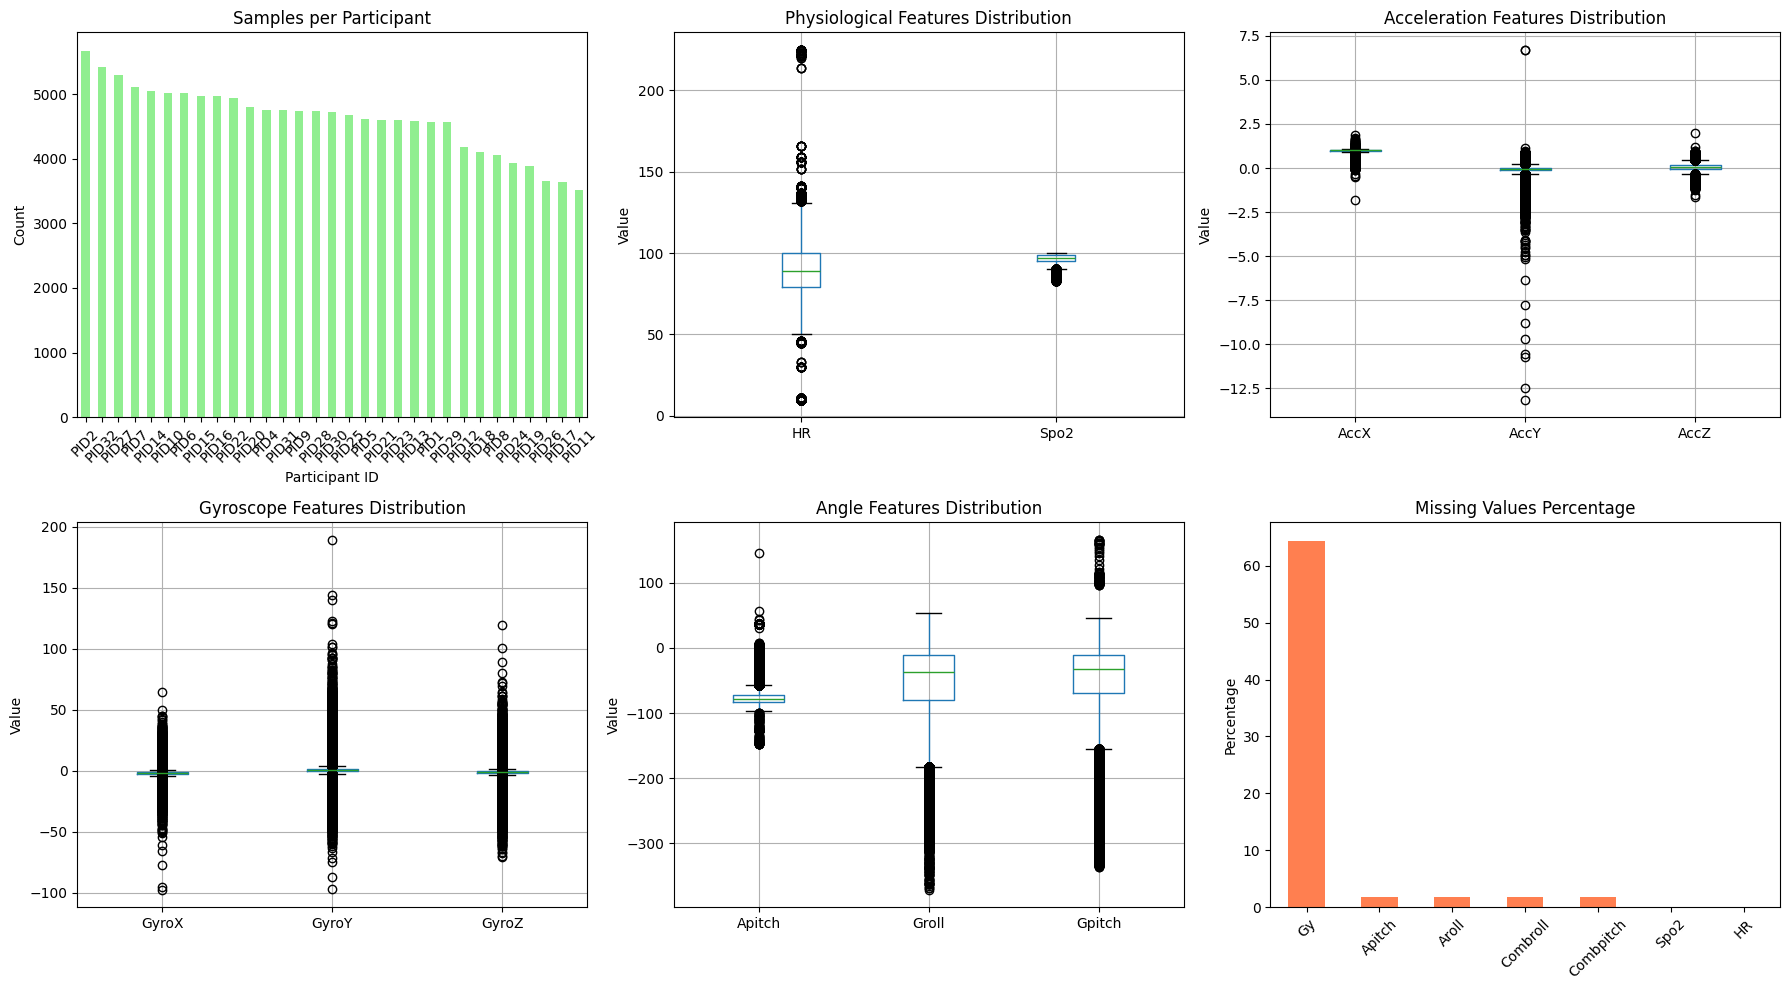


Data types after conversion:
Datetime      object
HR           float64
Spo2         float64
AccX         float64
AccY         float64
AccZ         float64
GyroX        float64
GyroY        float64
GyroZ        float64
Aroll        float64
Apitch       float64
Groll        float64
Gpitch       float64
Gy           float64
Combroll     float64
Combpitch    float64
PID           object
dtype: object


In [ ]:
print("Dataset Information:")
print(combined_df.info())

print("\nConverting object columns to numeric...")
for col in ['HR', 'Spo2', 'Aroll']:
    if col in combined_df.columns and combined_df[col].dtype == 'object':
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
        print(f"Converted {col} to numeric")

print("\nDataset Statistics:")
print(combined_df[selected_features].describe())
print("\nMissing Values:")
missing_values = combined_df.isnull().sum()
print(missing_values[missing_values > 0])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

combined_df['PID'].value_counts().plot(kind='bar', ax=axes[0, 0], color='lightgreen')
axes[0, 0].set_title('Samples per Participant')
axes[0, 0].set_xlabel('Participant ID')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

hr_spo2_data = combined_df[['HR', 'Spo2']].apply(pd.to_numeric, errors='coerce')
hr_spo2_data.boxplot(ax=axes[0, 1])
axes[0, 1].set_title('Physiological Features Distribution')
axes[0, 1].set_ylabel('Value')

combined_df[['AccX', 'AccY', 'AccZ']].boxplot(ax=axes[0, 2])
axes[0, 2].set_title('Acceleration Features Distribution')
axes[0, 2].set_ylabel('Value')

combined_df[['GyroX', 'GyroY', 'GyroZ']].boxplot(ax=axes[1, 0])
axes[1, 0].set_title('Gyroscope Features Distribution')
axes[1, 0].set_ylabel('Value')

angle_data = combined_df[['Apitch', 'Groll', 'Gpitch']].apply(pd.to_numeric, errors='coerce')
angle_data.boxplot(ax=axes[1, 1])
axes[1, 1].set_title('Angle Features Distribution')
axes[1, 1].set_ylabel('Value')

missing_pct = (combined_df.isnull().sum() / len(combined_df)) * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)
if len(missing_pct) > 0:
    missing_pct.plot(kind='bar', ax=axes[1, 2], color='coral')
    axes[1, 2].set_title('Missing Values Percentage')
    axes[1, 2].set_ylabel('Percentage')
    axes[1, 2].tick_params(axis='x', rotation=45)
else:
    axes[1, 2].text(0.5, 0.5, 'No Missing Values', ha='center', va='center')
    axes[1, 2].set_title('Missing Values')

plt.tight_layout()
plt.show()

print("\nData types after conversion:")
print(combined_df.dtypes)

In [ ]:
print("Starting preprocessing...")

df_processed = combined_df.copy()

print("Filling missing values with median...")
for col in selected_features:
    if col in df_processed.columns:
        if df_processed[col].dtype == 'object':
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')

        median_val = df_processed[col].median()
        missing_before = df_processed[col].isnull().sum()
        df_processed[col].fillna(median_val, inplace=True)

        if missing_before > 0:
            print(f"  {col}: Filled {missing_before} missing values with median {median_val:.2f}")

print(f"\nRemaining samples after preprocessing: {len(df_processed)}")
print(f"Missing values after preprocessing: {df_processed[selected_features].isnull().sum().sum()}")

feature_cols = [col for col in selected_features if col in df_processed.columns]
X = df_processed[feature_cols].values

print(f"\nFeature matrix shape before scaling: {X.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"Features used: {feature_cols}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nFeature matrix shape after scaling: {X_scaled.shape}")
print(f"Scaled data statistics:")
print(f"  Mean (should be ~0): {X_scaled.mean():.8f}")
print(f"  Std (should be ~1): {X_scaled.std():.8f}")
print(f"  Min: {X_scaled.min():.4f}")
print(f"  Max: {X_scaled.max():.4f}")

Starting preprocessing...
Filling missing values with median...
  HR: Filled 2 missing values with median 89.00
  Spo2: Filled 2 missing values with median 96.80
  Aroll: Filled 2648 missing values with median -3.39
  Apitch: Filled 2648 missing values with median -79.16
  Gy: Filled 92259 missing values with median -11.63
  Combroll: Filled 2648 missing values with median -35.43
  Combpitch: Filled 2648 missing values with median -33.40

Remaining samples after preprocessing: 143288
Missing values after preprocessing: 0

Feature matrix shape before scaling: (143288, 15)
Number of features: 15
Features used: ['HR', 'Spo2', 'AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Aroll', 'Apitch', 'Groll', 'Gpitch', 'Gy', 'Combroll', 'Combpitch']

Feature matrix shape after scaling: (143288, 15)
Scaled data statistics:
  Mean (should be ~0): 0.00000000
  Std (should be ~1): 1.00000000
  Min: -56.2247
  Max: 35.4473


In [ ]:
def create_sequences(X, sequence_length=50):
    X_seq = []

    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i+sequence_length])

    return np.array(X_seq)

SEQUENCE_LENGTH = 50

print(f"Creating sequences with length {SEQUENCE_LENGTH}...")
X_sequences = create_sequences(X_scaled, SEQUENCE_LENGTH)

print(f"\nSequence Creation Summary:")
print(f"  Total sequences created: {len(X_sequences):,}")
print(f"  Sequence shape: {X_sequences.shape}")
print(f"  Each sequence: {SEQUENCE_LENGTH} timesteps × {X_sequences.shape[2]} features")
print(f"  Memory usage: {X_sequences.nbytes / (1024**2):.2f} MB")

X_train, X_test = train_test_split(X_sequences, test_size=0.2, random_state=42, shuffle=True)

print(f"\nTrain/Test Split:")
print(f"  Training set: {X_train.shape[0]:,} sequences ({X_train.shape[0]/len(X_sequences)*100:.1f}%)")
print(f"  Testing set: {X_test.shape[0]:,} sequences ({X_test.shape[0]/len(X_sequences)*100:.1f}%)")
print(f"  Training data size: {X_train.nbytes / (1024**2):.2f} MB")
print(f"  Testing data size: {X_test.nbytes / (1024**2):.2f} MB")

Creating sequences with length 50...

Sequence Creation Summary:
  Total sequences created: 143,238
  Sequence shape: (143238, 50, 15)
  Each sequence: 50 timesteps × 15 features
  Memory usage: 819.61 MB

Train/Test Split:
  Training set: 114,590 sequences (80.0%)
  Testing set: 28,648 sequences (20.0%)
  Training data size: 655.69 MB
  Testing data size: 163.93 MB


In [ ]:
input_shape = (SEQUENCE_LENGTH, len(feature_cols))

print("Building LSTM Model...")
print(f"Input shape: {input_shape}")

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=input_shape, name='lstm_1'),
    Dropout(0.3, name='dropout_1'),
    LSTM(64, return_sequences=True, name='lstm_2'),
    Dropout(0.3, name='dropout_2'),
    LSTM(32, return_sequences=False, name='lstm_3'),
    Dropout(0.2, name='dropout_3'),
    Dense(64, activation='relu', name='dense_1'),
    Dropout(0.2, name='dropout_4'),
    Dense(len(feature_cols), activation='linear', name='output')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

print("\nModel Architecture:")
model.summary()

print(f"\nModel Configuration:")
print(f"  Input: Sequences of {SEQUENCE_LENGTH} timesteps with {len(feature_cols)} features")
print(f"  Output: {len(feature_cols)} predicted feature values")
print(f"  Total trainable parameters: {model.count_params():,}")
print(f"  Optimizer: Adam (learning_rate=0.001)")
print(f"  Loss function: Mean Squared Error (MSE)")
print(f"  Metrics: MAE, MSE")

Building LSTM Model...
Input shape: (50, 15)

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,639 (541.56 KB)

 Trainable params: 138,639 (541.56 KB)

 Non-trainable params: 0 (0.00 B)


Model Configuration:
  Input: Sequences of 50 timesteps with 15 features
  Output: 15 predicted feature values
  Total trainable parameters: 138,639
  Optimizer: Adam (learning_rate=0.001)
  Loss function: Mean Squared Error (MSE)
  Metrics: MAE, MSE


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=0.00001,
    verbose=1
)

print("="*70)
print("STARTING MODEL TRAINING (OPTIMIZED)")
print("="*70)
print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {int(len(X_train) * 0.2):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Batch size: 128 (increased for faster training)")
print(f"Max epochs: 30 (reduced to prevent timeout)")
print(f"Early stopping patience: 8 epochs")
print("="*70)

history = model.fit(
    X_train,
    X_train[:, -1, :],
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n" + "="*70)
print("TRAINING COMPLETED")
print("="*70)
print(f"Total epochs trained: {len(history.history['loss'])}")
print(f"Best validation loss: {min(history.history['val_loss']):.6f}")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")
print("="*70)

STARTING MODEL TRAINING (OPTIMIZED)
Training samples: 114,590
Validation samples: 22,918
Test samples: 28,648
Batch size: 128 (increased for faster training)
Max epochs: 30 (reduced to prevent timeout)
Early stopping patience: 8 epochs
Epoch 1/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 197s 274ms/step - loss: 0.1282 - mae: 0.2199 - mse: 0.1282 - val_loss: 0.0285 - val_mae: 0.1045 - val_mse: 0.0285 - learning_rate: 1.2500e-04
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 209s 292ms/step - loss: 0.1312 - mae: 0.2213 - mse: 0.1312 - val_loss: 0.0274 - val_mae: 0.1023 - val_mse: 0.0274 - learning_rate: 1.2500e-04
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 198s 276ms/step - loss: 0.1269 - mae: 0.2202 - mse: 0.1269 - val_loss: 0.0282 - val_mae: 0.1043 - val_mse: 0.0282 - learning_rate: 1.2500e-04
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 206s 287ms/step - loss: 0.1265 - mae: 0.2202 - mse: 0.1265 - val_loss: 0.0276 - val_mae: 0.1029 - val_mse: 0.0276 - learning_rate: 1.2500e-04
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━

Evaluating model on test set...

TEST SET EVALUATION METRICS
Mean Squared Error (MSE):     0.030265
Mean Absolute Error (MAE):    0.102827
R² Score:                     0.969906
Root Mean Squared Error:      0.173968

PER-FEATURE METRICS:
----------------------------------------------------------------------
Feature         MSE          MAE          R² Score    
----------------------------------------------------------------------
HR              0.034214     0.125750     0.966075    
Spo2            0.033170     0.132081     0.966925    
AccX            0.027520     0.075939     0.973871    
AccY            0.024778     0.081233     0.975631    
AccZ            0.035014     0.136578     0.965989    
GyroX           0.047493     0.127328     0.952461    
GyroY           0.045444     0.116088     0.955838    
GyroZ           0.046562     0.114250     0.952117    
Aroll           0.027101     0.096097     0.972262    
Apitch          0.031149     0.102615     0.970062    
Groll         

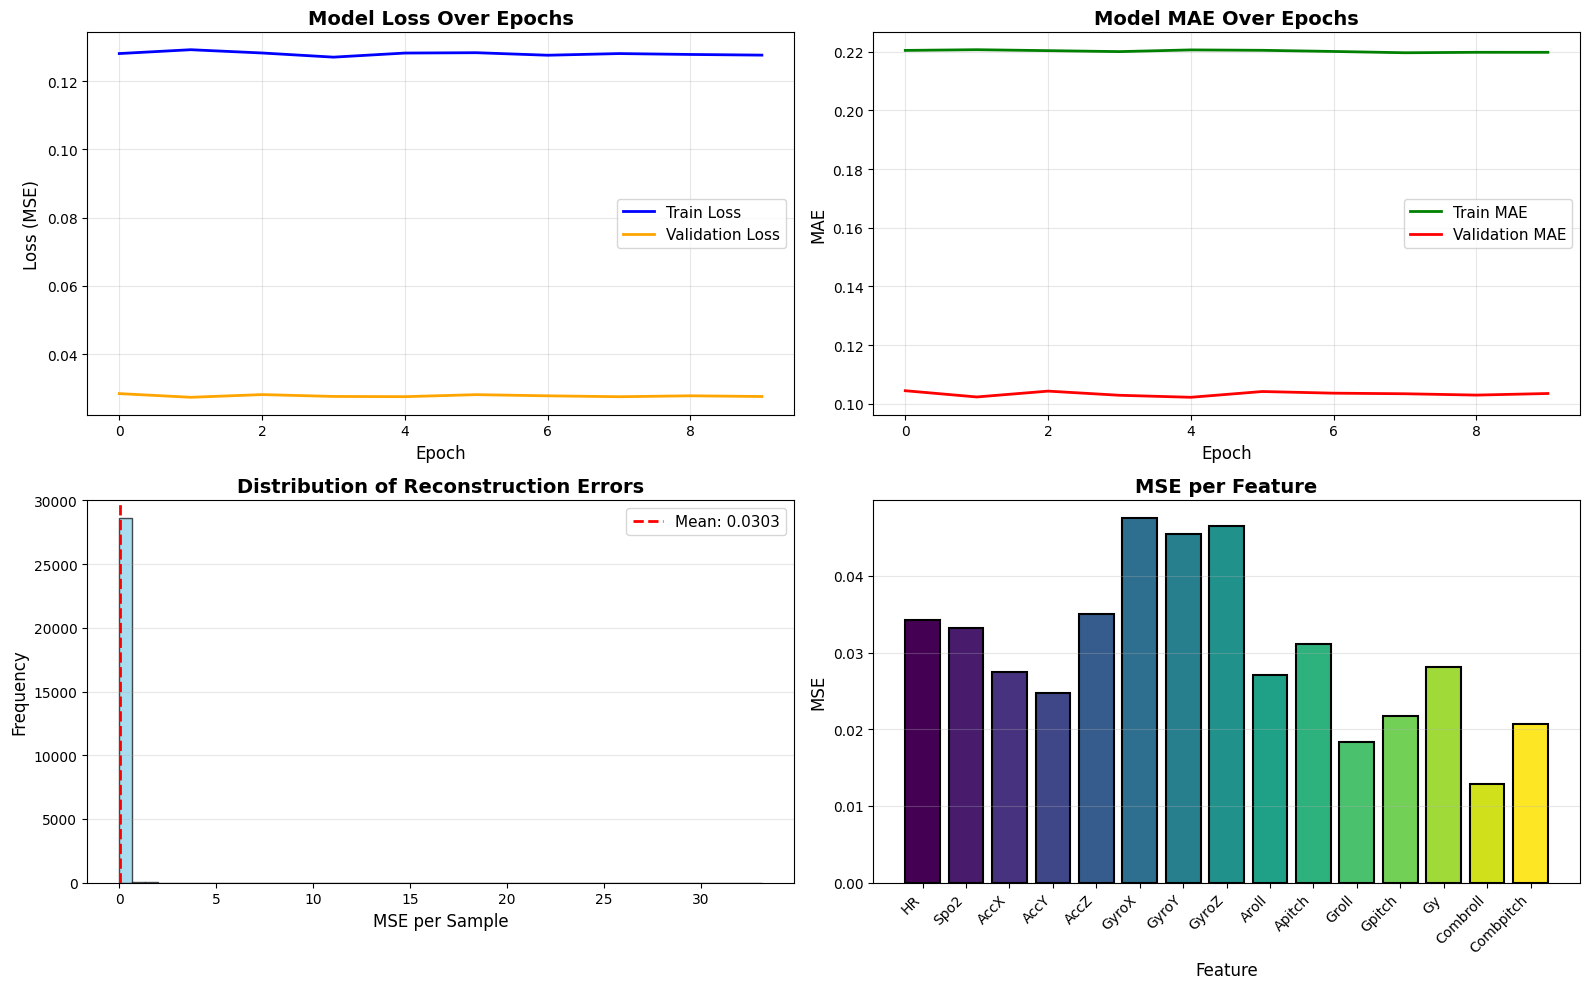

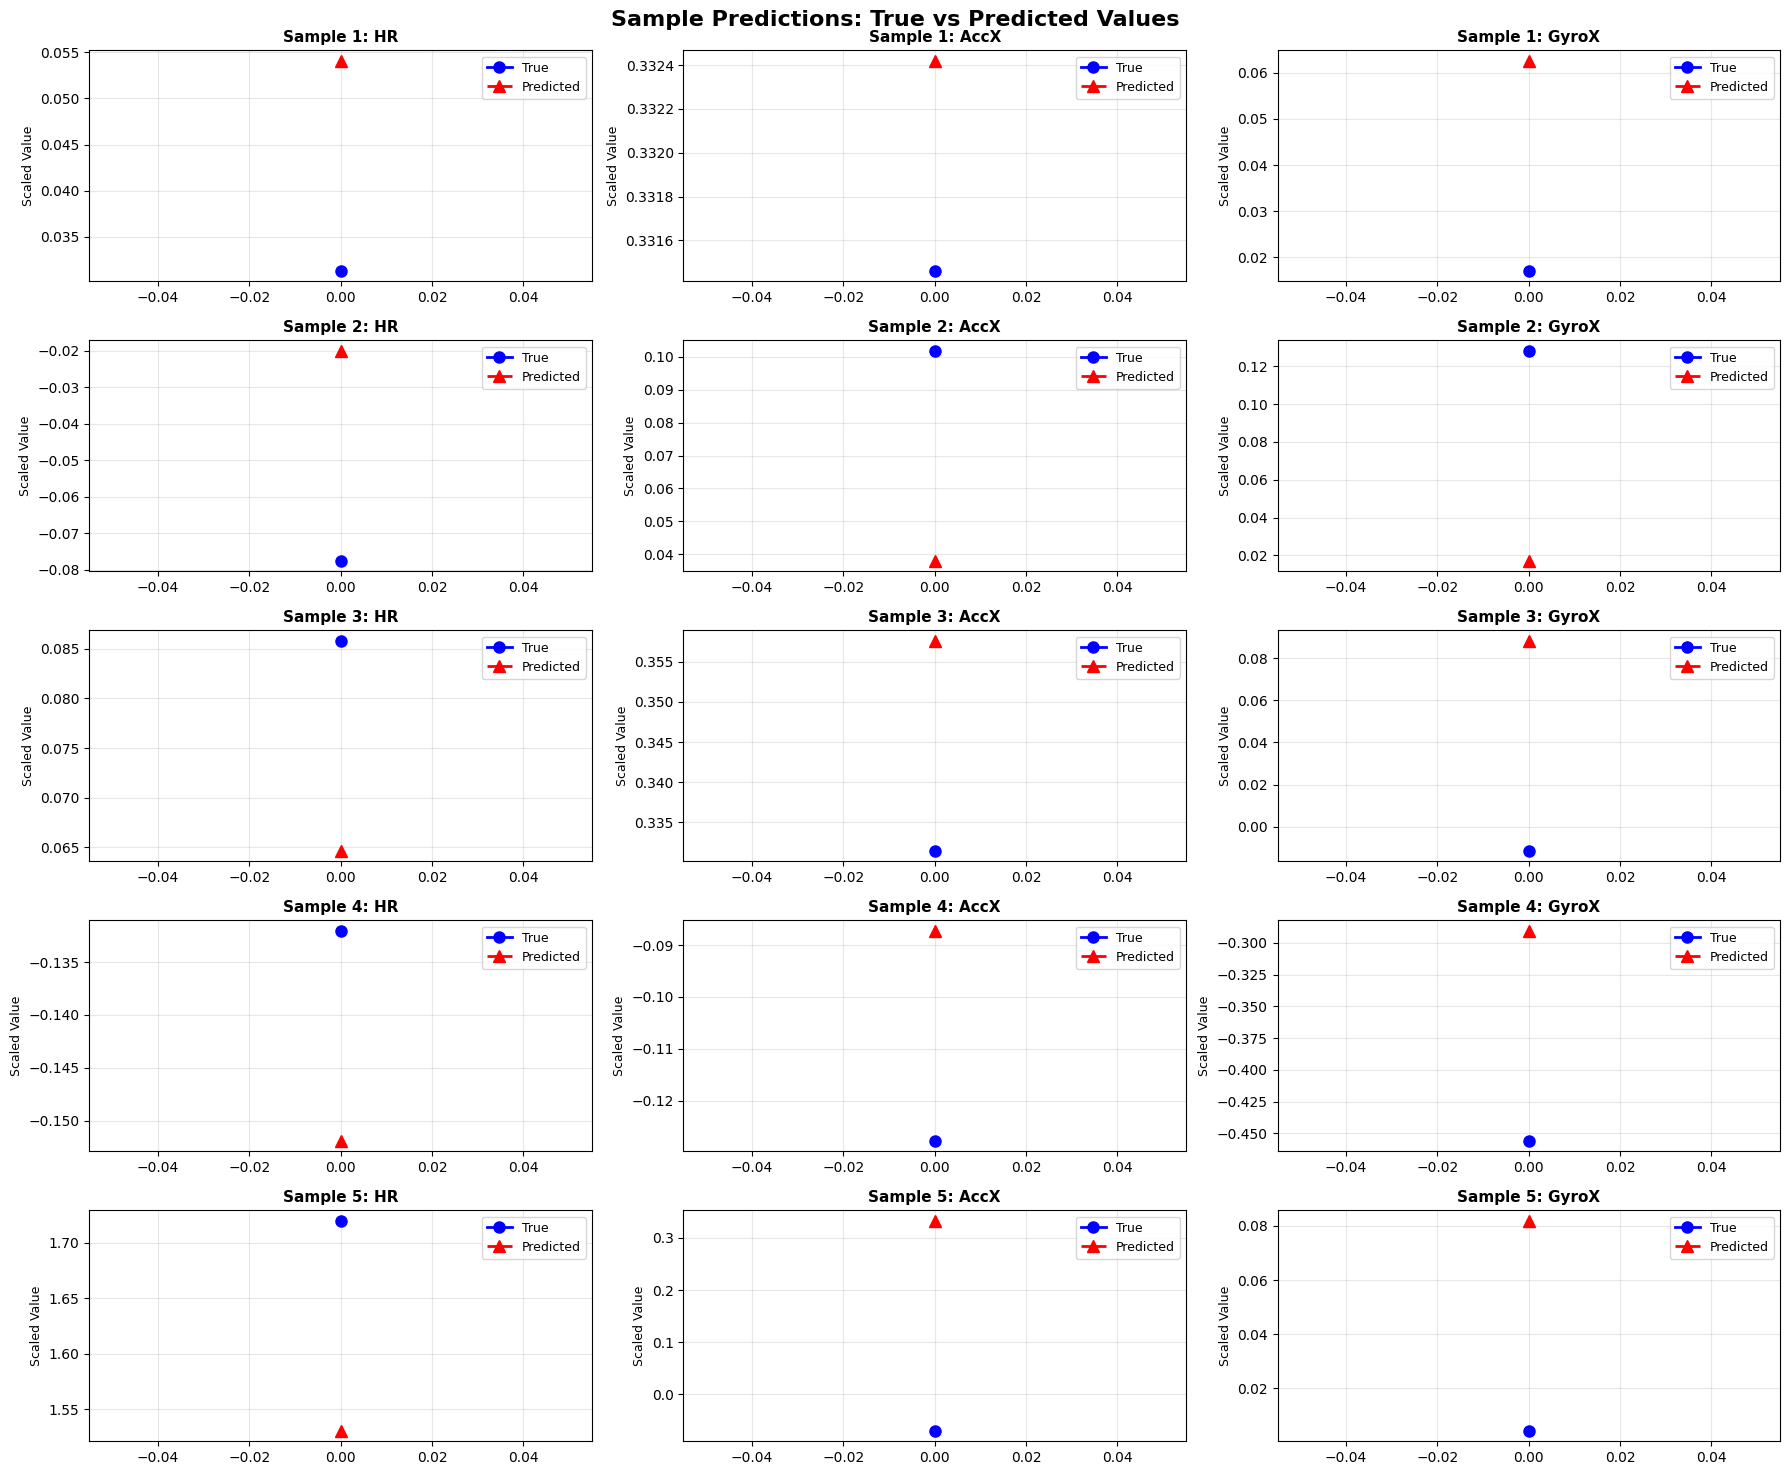

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Evaluating model on test set...")

y_pred = model.predict(X_test, verbose=0)
y_true = X_test[:, -1, :]

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n" + "="*70)
print("TEST SET EVALUATION METRICS")
print("="*70)
print(f"Mean Squared Error (MSE):     {mse:.6f}")
print(f"Mean Absolute Error (MAE):    {mae:.6f}")
print(f"R² Score:                     {r2:.6f}")
print(f"Root Mean Squared Error:      {np.sqrt(mse):.6f}")
print("="*70)

per_feature_mse = np.mean((y_pred - y_true) ** 2, axis=0)
per_feature_mae = np.mean(np.abs(y_pred - y_true), axis=0)
per_feature_r2 = [r2_score(y_true[:, i], y_pred[:, i]) for i in range(len(feature_cols))]

print("\nPER-FEATURE METRICS:")
print("-" * 70)
print(f"{'Feature':<15} {'MSE':<12} {'MAE':<12} {'R² Score':<12}")
print("-" * 70)
for i, feature in enumerate(feature_cols):
    print(f"{feature:<15} {per_feature_mse[i]:<12.6f} {per_feature_mae[i]:<12.6f} {per_feature_r2[i]:<12.6f}")
print("-" * 70)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2, color='blue')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history.history['mae'], label='Train MAE', linewidth=2, color='green')
axes[0, 1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='red')
axes[0, 1].set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('MAE', fontsize=12)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

sample_errors = np.mean((y_pred - y_true) ** 2, axis=1)
axes[1, 0].hist(sample_errors, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[1, 0].axvline(sample_errors.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {sample_errors.mean():.4f}')
axes[1, 0].set_title('Distribution of Reconstruction Errors', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('MSE per Sample', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='y')

colors = plt.cm.viridis(np.linspace(0, 1, len(feature_cols)))
bars = axes[1, 1].bar(range(len(feature_cols)), per_feature_mse, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_title('MSE per Feature', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Feature', fontsize=12)
axes[1, 1].set_ylabel('MSE', fontsize=12)
axes[1, 1].set_xticks(range(len(feature_cols)))
axes[1, 1].set_xticklabels(feature_cols, rotation=45, ha='right', fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

n_samples = min(5, len(X_test))
fig, axes = plt.subplots(n_samples, 3, figsize=(18, 3*n_samples))

selected_features_viz = ['HR', 'AccX', 'GyroX']
for sample_idx in range(n_samples):
    for feat_idx, feat_name in enumerate(selected_features_viz):
        if feat_name in feature_cols:
            col_idx = feature_cols.index(feat_name)

            axes[sample_idx, feat_idx].plot(y_true[sample_idx, col_idx], 'bo-',
                                           label='True', linewidth=2, markersize=8)
            axes[sample_idx, feat_idx].plot(y_pred[sample_idx, col_idx], 'r^--',
                                           label='Predicted', linewidth=2, markersize=8)
            axes[sample_idx, feat_idx].set_title(f'Sample {sample_idx+1}: {feat_name}',
                                                fontsize=11, fontweight='bold')
            axes[sample_idx, feat_idx].legend(fontsize=9)
            axes[sample_idx, feat_idx].grid(True, alpha=0.3)
            axes[sample_idx, feat_idx].set_ylabel('Scaled Value', fontsize=9)

plt.suptitle('Sample Predictions: True vs Predicted Values', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
save_path = '/content/drive/MyDrive/Project Talaria(IoT)/models'
os.makedirs(save_path, exist_ok=True)

print("="*70)
print("SAVING MODEL")
print("="*70)

keras_model_path = os.path.join(save_path, 'lstm_sensor_model.h5')
model.save(keras_model_path)
keras_size_mb = os.path.getsize(keras_model_path) / (1024 * 1024)
print(f"Keras model saved: {keras_model_path}")
print(f"  Size: {keras_size_mb:.2f} MB")

print("\nConverting to TensorFlow Lite format...")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

tflite_path = os.path.join(save_path, 'sensor_model.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

tflite_size_mb = len(tflite_model) / (1024 * 1024)
compression_ratio = keras_size_mb / tflite_size_mb

print(f"\nTFLite model saved: {tflite_path}")
print(f"  Size: {tflite_size_mb:.2f} MB")
print(f"  Compression: {compression_ratio:.2f}x smaller")
print(f"  Size reduction: {((keras_size_mb - tflite_size_mb) / keras_size_mb * 100):.1f}%")
print("="*70)

SAVING MODEL
Keras model saved: /content/drive/MyDrive/Project Talaria(IoT)/models/lstm_sensor_model.h5
  Size: 1.64 MB

Converting to TensorFlow Lite format...
Saved artifact at '/tmp/tmpkupmdo7l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 15), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  132814959395088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132814959397776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132814959394896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132814959395472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132814959395280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132814959395856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132814959397584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132814959395664: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("TFLite Model Input/Output Details:")
print(f"Input shape: {input_details[0]['shape']}")
print(f"Input dtype: {input_details[0]['dtype']}")
print(f"Output shape: {output_details[0]['shape']}")
print(f"Output dtype: {output_details[0]['dtype']}")

test_samples = 100
keras_predictions = []
tflite_predictions = []

for i in range(test_samples):
    test_input = X_test[i:i+1].astype(np.float32)

    keras_pred = model.predict(test_input, verbose=0)
    keras_predictions.append(keras_pred)

    interpreter.set_tensor(input_details[0]['index'], test_input)
    interpreter.invoke()
    tflite_pred = interpreter.get_tensor(output_details[0]['index'])
    tflite_predictions.append(tflite_pred)

keras_predictions = np.array(keras_predictions).squeeze()
tflite_predictions = np.array(tflite_predictions).squeeze()

diff = np.abs(keras_predictions - tflite_predictions)
avg_diff = np.mean(diff)
max_diff = np.max(diff)
relative_error = (avg_diff / np.mean(np.abs(keras_predictions))) * 100

print("\nTFLite vs Keras Comparison:")
print(f"Average absolute difference: {avg_diff:.8f}")
print(f"Maximum absolute difference: {max_diff:.8f}")
print(f"Relative error: {relative_error:.6f}%")
print(f"Correlation coefficient: {np.corrcoef(keras_predictions.flatten(), tflite_predictions.flatten())[0,1]:.8f}")

TFLite Model Input/Output Details:
Input shape: [ 1 50 15]
Input dtype: <class 'numpy.float32'>
Output shape: [ 1 15]
Output dtype: <class 'numpy.float32'>

TFLite vs Keras Comparison:
Average absolute difference: 0.00383435
Maximum absolute difference: 0.03125238
Relative error: 0.771211%
Correlation coefficient: 0.99998014


In [ ]:
import pickle
import json
from datetime import datetime

scaler_path = os.path.join(save_path, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

metadata = {
    'model_info': {
        'model_name': 'LSTM Sensor Predictor',
        'model_type': 'Time Series Regression',
        'framework': 'TensorFlow/Keras',
        'tensorflow_version': tf.__version__,
        'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    },
    'dataset_info': {
        'total_samples': int(len(combined_df)),
        'total_sequences': int(len(X_sequences)),
        'training_sequences': int(len(X_train)),
        'validation_sequences': int(len(X_train) * 0.2),
        'test_sequences': int(len(X_test)),
        'participants': int(combined_df['PID'].nunique()),
        'sequence_length': SEQUENCE_LENGTH,
    },
    'model_architecture': {
        'input_shape': [SEQUENCE_LENGTH, len(feature_cols)],
        'output_shape': [len(feature_cols)],
        'features': feature_cols,
        'num_features': len(feature_cols),
        'total_parameters': int(model.count_params()),
    },
    'training_config': {
        'epochs_completed': len(history.history['loss']),
        'batch_size': 128,
        'optimizer': 'Adam',
        'initial_learning_rate': 0.001,
        'loss_function': 'mean_squared_error',
    },
    'performance_metrics': {
        'test_mse': float(mse),
        'test_mae': float(mae),
        'test_rmse': float(np.sqrt(mse)),
        'test_r2_score': float(r2),
        'test_r2_percentage': f"{float(r2) * 100:.2f}%",
        'best_val_loss': float(min(history.history['val_loss'])),
        'final_train_loss': float(history.history['loss'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1]),
    },
    'per_feature_performance': {
        feature: {
            'mse': float(per_feature_mse[i]),
            'mae': float(per_feature_mae[i]),
            'r2_score': float(per_feature_r2[i]),
            'r2_percentage': f"{float(per_feature_r2[i]) * 100:.2f}%"
        }
        for i, feature in enumerate(feature_cols)
    },
    'deployment_info': {
        'tflite_model_file': 'sensor_model.tflite',
        'scaler_file': 'scaler.pkl',
        'input_requirements': f'{SEQUENCE_LENGTH} consecutive timesteps of {len(feature_cols)} sensor readings',
        'preprocessing': 'StandardScaler (mean=0, std=1)',
        'output_format': f'{len(feature_cols)} predicted sensor values for next timestep',
    },
    'firebase_ml_compatibility': {
        'format': 'TensorFlow Lite',
        'compatible': True,
        'model_size_mb': f'{tflite_size_mb:.2f}',
        'optimization': 'DEFAULT',
    }
}

metadata_path = os.path.join(save_path, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

readme_content = f"""# LSTM Sensor Prediction Model

## Model Performance Summary
- R2 Score: {r2*100:.2f}%
- Mean Absolute Error: {mae:.6f}
- Root Mean Squared Error: {np.sqrt(mse):.6f}

## Files in this Directory
1. sensor_model.tflite - TensorFlow Lite model ({tflite_size_mb:.2f} MB)
2. lstm_sensor_model.h5 - Full Keras model ({keras_size_mb:.2f} MB)
3. scaler.pkl - StandardScaler for preprocessing
4. model_metadata.json - Complete model specifications

## Input Format
- Shape: [{SEQUENCE_LENGTH}, {len(feature_cols)}]
- Type: float32
- Features: {', '.join(feature_cols)}
- Preprocessing: Standardize using scaler.pkl

## Output Format
- Shape: [{len(feature_cols)}]
- Type: float32
- Represents: Predicted next sensor values

## Firebase ML Integration
1. Upload sensor_model.tflite to Firebase Console
2. Use Firebase ML Kit to download and run the model
3. Input: 50 consecutive sensor readings
4. Output: Predicted next sensor values

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

readme_path = os.path.join(save_path, 'README.md')
with open(readme_path, 'w') as f:
    f.write(readme_content)

print("Model artifacts saved successfully")
print(f"Location: {save_path}")
print(f"\nFiles created:")
print(f"- sensor_model.tflite ({tflite_size_mb:.2f} MB)")
print(f"- lstm_sensor_model.h5 ({keras_size_mb:.2f} MB)")
print(f"- scaler.pkl")
print(f"- model_metadata.json")
print(f"- README.md")
print(f"\nModel Performance:")
print(f"R2 Score: {r2*100:.2f}%")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {np.sqrt(mse):.6f}")

Model artifacts saved successfully
Location: /content/drive/MyDrive/Project Talaria(IoT)/models

Files created:
- sensor_model.tflite (0.19 MB)
- lstm_sensor_model.h5 (1.64 MB)
- scaler.pkl
- model_metadata.json
- README.md

Model Performance:
R2 Score: 96.99%
MAE: 0.102827
RMSE: 0.173968
